In [19]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# Extend PATH Variable
import sys
sys.path.append("../../../../src/")

# NanoNets Simulation Tool
import nanonets
import nanonets_utils

from scipy.optimize import curve_fit
plt.style.use(["science","bright","grid"])

def linear_func(x,a,b,c):
    return a*(x-b)+c
def power_law(x,a,b):
    return a*x**b

In [20]:
N_p_min = 3
N_p_max = 16
N_p_val = np.arange(N_p_min,N_p_max+1)
folder  = "/home/j/j_mens07/phd/data/1_funding_period/current/magnitude/"
data    = {N_p : pd.read_csv(f"{folder}Nx={N_p}_Ny={N_p}_Nz=1_Ne=8.csv") for N_p in N_p_val}
states  = {N_p : pd.read_csv(f"{folder}mean_state_Nx={N_p}_Ny={N_p}_Nz=1_Ne=8.csv") for N_p in N_p_val}

In [21]:
start   = 1700
slopes  = []
params  = []
params2 = []

for i, N_p in enumerate(N_p_val):

    df      = data[N_p].copy()
    df      = df.sort_values(by='Current', ignore_index=True).dropna()
    x_end   = df.loc[start:,'E1'].values
    y_end   = df.loc[start:,'Current'].values

    p, cov  = curve_fit(linear_func, y_end, x_end)
    params.append(p)
    slope   = p[0]
    slopes.append(slope)

    x_end   = df.loc[start:,'E1'].values*1000
    y_end   = df.loc[start:,'Current'].values
    p, cov  = curve_fit(linear_func, x_end, y_end)
    params2.append(p)
    
slopes = np.array(slopes)
p, cov = curve_fit(power_law, N_p_val**2, slopes)

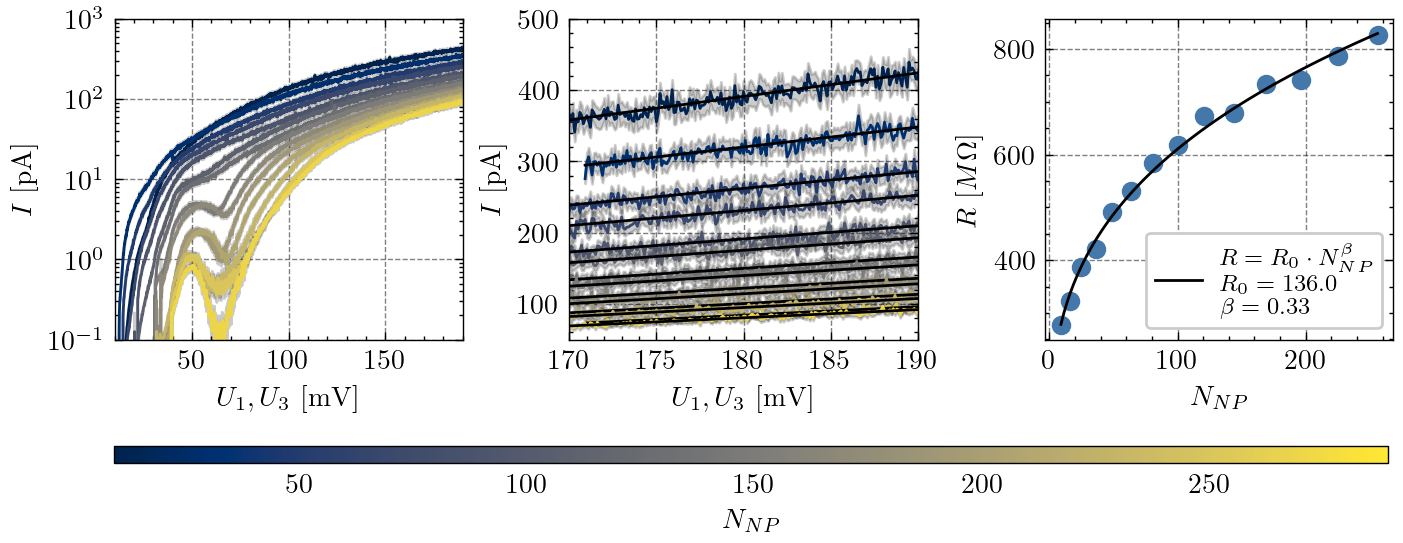

In [22]:
fig         = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2.0)
fig.set_figheight(fig.get_figheight()*0.8)

colormap    = 'cividis'
cmap        = plt.get_cmap(colormap)
ax1         = fig.add_subplot(1,3,1)
ax2         = fig.add_subplot(1,3,2)
ax3         = fig.add_subplot(1,3,3)

for i, N_p in enumerate(N_p_val):

    df      = data[N_p].copy()
    df      = df.sort_values(by='E1', ignore_index=True)
    x_vals  = df['E1'].values.copy()*1000
    y_vals  = df['Current'].values.copy()
    error   = df['Error'].values.copy()

    ax1.plot(x_vals, y_vals, color=cmap((i)/(N_p_max-N_p_min+1)), label=N_p)
    ax1.fill_between(x_vals, y_vals-error, y_vals+error, color='black', alpha=0.2)
    ax1.set_xlabel("$U_1,U_3$ [mV]")
    ax1.set_ylabel("$I$ [pA]")
    ax1.set_yscale('log')
    ax1.set_ylim(0.1,1000)
    ax1.set_xlim(10,190)

    x_vals  = df.loc[start:,'E1'].values.copy()*1000
    y_vals  = df.loc[start:,'Current'].values.copy()
    error   = df.loc[start:,'Error'].values.copy()

    ax2.plot(x_vals, y_vals, color=cmap((i)/(N_p_max-N_p_min+1)))
    ax2.fill_between(x_vals, y_vals-error, y_vals+error, color='black', alpha=0.2)
    ax2.plot(x_vals, linear_func(x_vals, *params2[i]), 'black')
    ax2.set_xlabel("$U_1,U_3$ [mV]")
    ax2.set_ylabel("$I$ [pA]")
    ax2.set_xlim(170,190)
    ax2.set_ylim(50,500)

x_fit = np.linspace(np.min(N_p_val**2),np.max(N_p_val**2),100)
ax3.plot(N_p_val**2, slopes*1e6, 'o')
ax3.plot(x_fit, power_law(x_fit,*p)*1e6, '-', c='black', label='$R = R_0 \cdot N_{NP}^\\beta$\n '+f'$R_0 = {np.round(p[0]*1e6,1)}$\n $\\beta = {np.round(p[1],2)}$')
ax3.legend(fontsize='small')
# ax3.set_yscale('log')
# ax3.set_xscale('log')
ax3.set_xlabel("$N_{NP}$")
ax3.set_ylabel("$R$ [$M\Omega$]")
# ax3.set_ylim(1,3.5)

cbar_ax = fig.add_axes([0.08, -0.1, 0.91, 0.04])
norm    = mpl.colors.Normalize(vmin=N_p_val[0]**2, vmax=(N_p_val[-1]+1)**2)
cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)
fig.colorbar(cbar, cax=cbar_ax, label='$N_{NP}$', orientation='horizontal')

fig.savefig("../plots/current_magnitude_cubic_network.svg", transparent=True)
fig.savefig("../plots/current_magnitude_cubic_network.pdf", transparent=False)

## $$\alpha(N_{NP}) = \frac{R(N_{NP})}{R(81)} \approx \frac{A \cdot N_{NP}^{0.33}}{A\cdot81^{0.33}} = \left( \frac{N_{NP}}{81} \right)^{1/3}$$

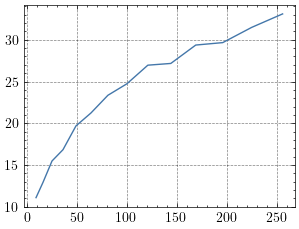

In [23]:
plt.plot(N_p_val**2, (slopes*1e6)/25)

In [24]:
base_system = 6
y           = slopes.copy()
base_slope  = y[base_system]
alphas      = np.round(y/base_slope,2)
alphas_eq   = np.round(((N_p_val**2)/81)**(1/3),2)
print(alphas)
print(alphas_eq)

[0.47 0.55 0.66 0.72 0.84 0.91 1.   1.06 1.15 1.16 1.26 1.27 1.35 1.42]
[0.48 0.58 0.68 0.76 0.85 0.92 1.   1.07 1.14 1.21 1.28 1.34 1.41 1.47]


In [25]:
N_p_min2    = 3
N_p_max2    = 15
N_p_val2    = np.arange(N_p_min2,N_p_max2+1)
folder2     = "/home/j/j_mens07/phd/data/1_funding_period/current/magnitude_scaled/"
data2       = {N_p : pd.read_csv(f"{folder2}Nx={N_p}_Ny={N_p}_Nz=1_Ne=8.csv") for N_p in N_p_val2}
states2     = {N_p : pd.read_csv(f"{folder2}mean_state_Nx={N_p}_Ny={N_p}_Nz=1_Ne=8.csv") for N_p in N_p_val2}

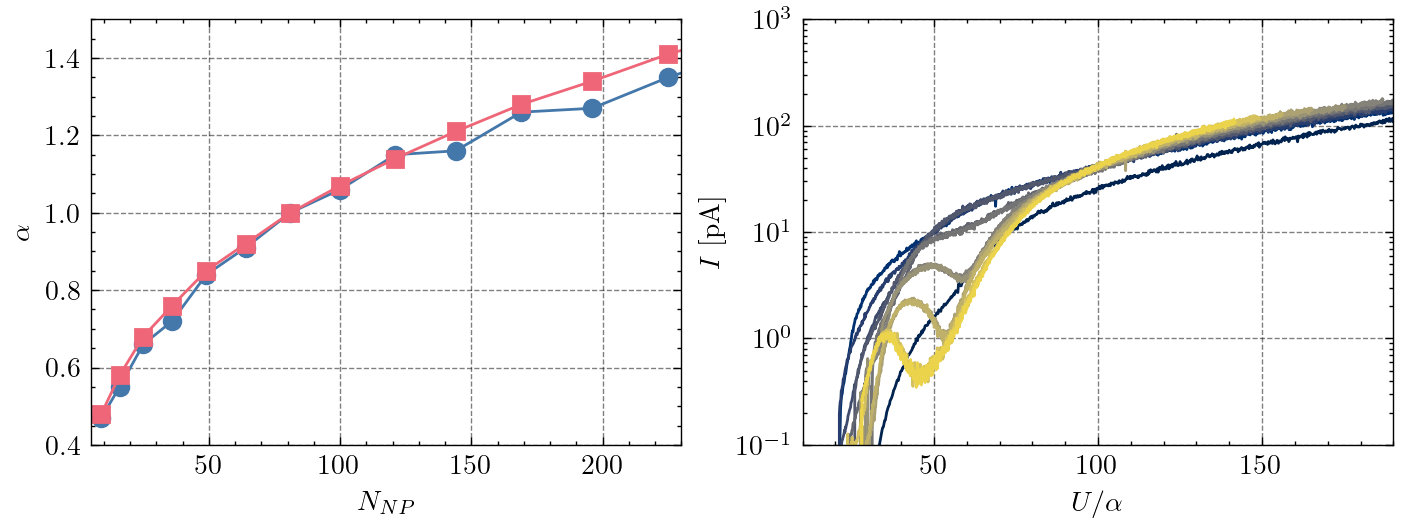

In [26]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2.0)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(N_p_val**2, alphas, 'o-')
ax1.plot(N_p_val**2, alphas_eq, 's-')
ax1.set_ylabel('$\\alpha$')
ax1.set_xlabel('$N_{NP}$')
ax1.set_xlim(5,230)
ax1.set_ylim(0.4,1.5)

for i, N_p in enumerate(range(N_p_min2, N_p_max2+1)):
    
    df      = data[N_p].copy()
    df      = df.sort_values(by='E1', ignore_index=True)
    x_vals  = df['E1'].values.copy()*1000
    y_vals  = df['Current'].values.copy()
    error   = df['Error'].values.copy()

    ax2.plot(x_vals/alphas_eq[i], y_vals, color=cmap((i)/(N_p_max2-N_p_min2+1)), label=N_p)

    ax2.set_xlabel("$U/\\alpha$")
    ax2.set_ylabel("$I$ [pA]")
    ax2.set_yscale('log')
    ax2.set_ylim(0.1,1000)
    ax2.set_xlim(10,190)

fig.savefig("../plots/current_magnitude_cubic_network_scaled.svg", transparent=True)
fig.savefig("../plots/current_magnitude_cubic_network_scaled.pdf", transparent=False)

In [138]:
N   = 5
a   = 0
b   = 1000
N_r = (N**2)-1
arr = states[N].iloc[a:b,:].corr().iloc[N_r].values.reshape(N,-1)
U_m = data1[N]['E1'].sort_values().values[b]*1000

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(arr, cmap='coolwarm', vmin=0, vmax=1, annot=True,
                  cbar_kws={'label':'$corr(\phi_{x,y},\phi_{'+f'{N-1},{N-1}'+'})$'},
                  fmt='.1f', annot_kws={"size":5}, center=0.5)

ax.invert_yaxis()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(f'$U \in [0,{U_m}]$ mV')

fig.savefig(f"../plots/corrs/corr_{N}_{N}.svg", transparent=True)
fig.savefig(f"../plots/corrs/corr_{N}_{N}.pdf", transparent=False)

ValueError: cannot reshape array of size 33 into shape (5,newaxis)

---

In [103]:
STOP

NameError: name 'STOP' is not defined

## Equilibrium Runs

In [79]:
V_min   = 0.5
V_max   = 1.0
V_arr   = np.linspace(V_min, V_max, 100, endpoint=True)

pre_jumps   = [0,10,50,100,500,1000,5000,10000,50000,100000,500000,1000000]
N_min       = 3
N_max       = 18
results     = {N : {eq_steps : np.loadtxt(f"data_equilibrium/N_{N}_th_{eq_steps}.csv") for eq_steps in pre_jumps} for N in np.arange(N_min,N_max+1)}

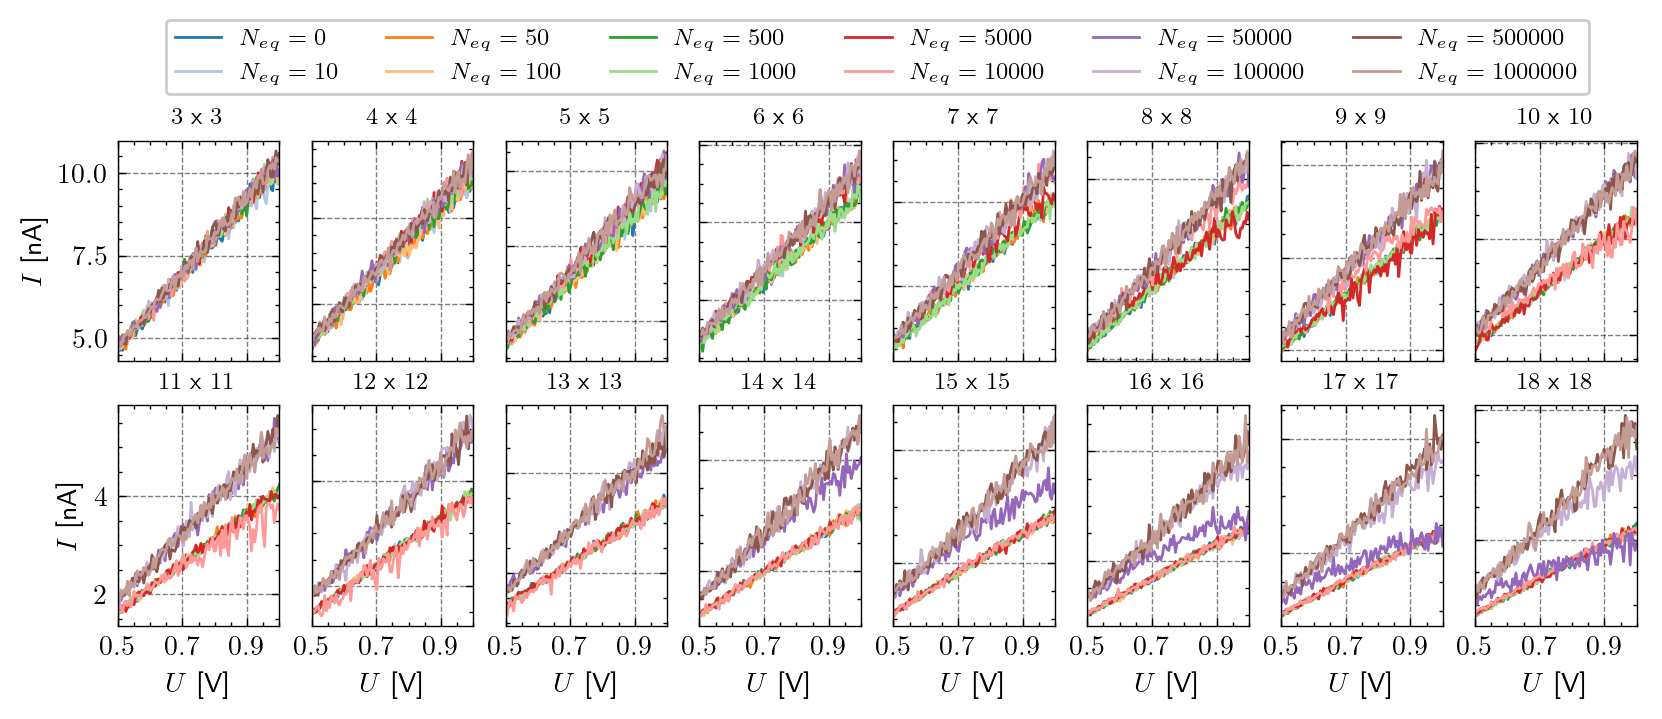

In [96]:
nrows   = 2
ncols   = 8
cmap    = plt.get_cmap('tab20')

with plt.style.context(["science", "bright", "grid"]):

    fig = plt.figure(dpi=200)
    fig.set_figwidth(fig.get_figwidth()*2.8)
    fig.set_figheight(fig.get_figheight()*1.2)

    for i, N in enumerate(range(N_min,N_max+1)):  

        ax = fig.add_subplot(nrows,ncols,i+1)

        for j, eq_jumps in enumerate(pre_jumps):

            ax.plot(V_arr, results[N][eq_jumps][:,2]/1000, label='$N_{eq}'+f' = {eq_jumps}$', c=cmap((j+0.5)/20))
        
        if i % ncols != 0:
            ax.set_yticklabels("")
        else:
            ax.set_ylabel("$I$ [nA]")
        
        if i < (nrows-1)*ncols:
            ax.set_xticklabels("")
        else:
            ax.set_xlabel("$U$ [V]")
        
        ax.set_xlim(0.5,1.0)
    
        if i == 0:
            ax.legend(fontsize='small', bbox_to_anchor=(4.7,1.38), loc='center', ncols=6)
        
        ax.set_xticks([0.5,0.7,0.9])
        ax.set_title(f"${N}$ x ${N}$", fontsize='small')

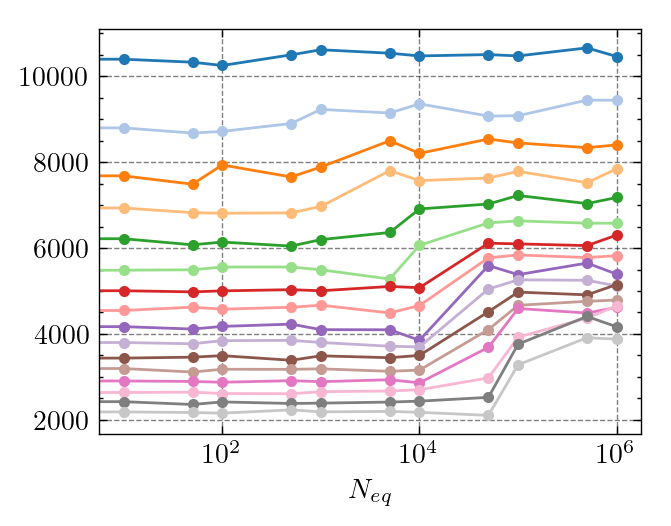

In [115]:
with plt.style.context(["science", "bright", "grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for j, N in enumerate(range(N_min, N_max+1)):
        
        vals = [np.max(results[N][eq_jumps][:,2]) for eq_jumps in pre_jumps]

        ax.plot(pre_jumps, vals, '.-', c=cmap((j+0.5)/20))
    
    ax.set_xscale('log')
    ax.set_xlabel('$N_{eq}$')

In [ ]:
[10000,10000,10000,10000,50000,50000,100000,100000,100000,100000]

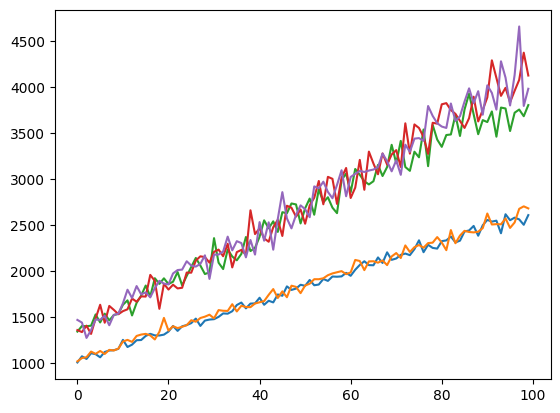

In [82]:
plt.plot(results[16][0][:,2])
plt.plot(results[16][10000][:,2])
plt.plot(results[16][100000][:,2])
plt.plot(results[16][500000][:,2])
plt.plot(results[16][1000000][:,2])

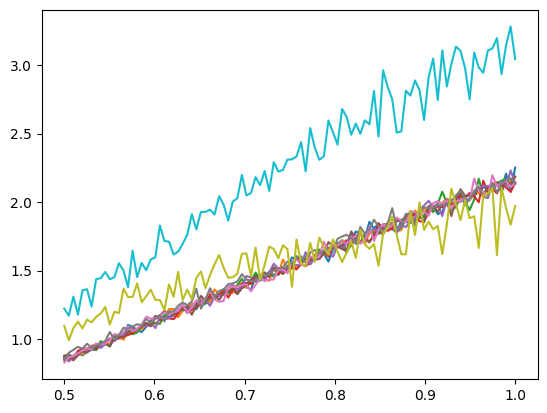

In [64]:
for j, eq_jumps in enumerate(pre_jumps):

    plt.plot(V_arr, results[18][eq_jumps][:,2]/1000)

In [14]:
# Node positions
N_particles = 50
seed        = 0

rng         = np.random.RandomState(seed)
angles      = rng.uniform(0,2*np.pi, N_particles)
radii       = np.sqrt(rng.uniform(0, 1, N_particles))
pos         = [(r * np.cos(a), r * np.sin(a)) for r, a in zip(radii, angles)]

G  = nx.Graph()

for i, p in enumerate(pos):
    G.add_node(i, pos=p)

tri     = Delaunay(pos)
edges   = set()
for simplex in tri.simplices:
    for i in range(3):
        edge = tuple(sorted([simplex[i], simplex[(i+1) % 3]]))
        edges.add(edge)

edges = list(edges)
G.add_edges_from(edges)
pos = {i : p for i, p in enumerate(pos)}

nx.draw(G, pos)

NameError: name 'nx' is not defined

---

In [ ]:
results_c_new   = {}
V_arr           = np.zeros((250,3))
V_min           = 0.0
V_max           = 1.0

for i,N in enumerate(range(3,13)):

    V_arr[:,0]          = scale[i]*np.linspace(V_min, V_max, 250, endpoint=True)
    topology_parameter  = return_cubic_topology(N)
    np_network_cubic    = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter)
    
    np_network_cubic.run_const_voltages(V_arr, 1, save_th=0.1)

    results_c_new[N] = np_network_cubic.return_output_values()

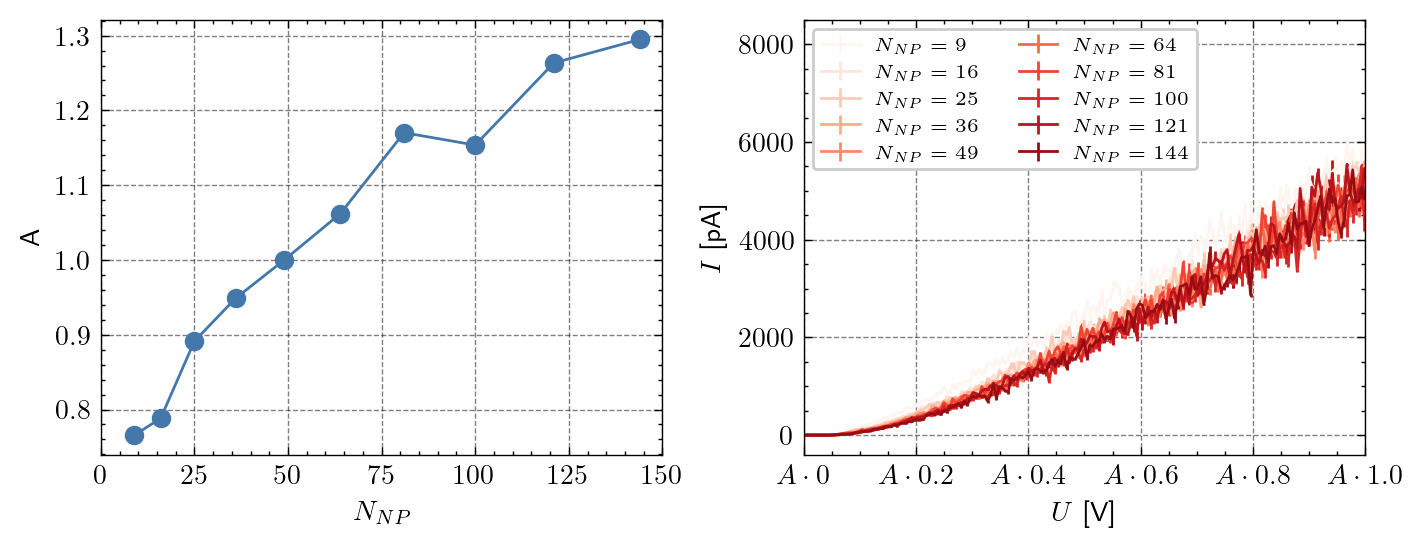

In [ ]:
with plt.style.context(["science", "bright", "grid"]):

    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*2)
    ax  = fig.add_subplot(1,2,1)
    ax.plot(np.arange(3,13)**2, scale, '-o')
    ax.set_xlim(0,150)
    ax.set_xlabel("$N_{NP}$")
    ax.set_ylabel("A")

    ax  = fig.add_subplot(1,2,2)
    for i, N in enumerate(range(3,13)):

        ax.errorbar(V_arr[:,0], results_c_new[N][:,2], results_c_new[N][:,3], c=cmap(i/len(results_c_new.keys())), label='$N_{NP} = '+f' {N*N}$')
    
    ax.set_ylabel("$I$ [pA]")
    ax.set_xlabel("$U$ [V]")
    ax.legend(fontsize='x-small', ncol=2)
    ax.set_xlim(0.0,1.0)
    ax.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
    ax.set_xticklabels([f"$A \cdot {i}$" for i in [0,0.2,0.4,0.6,0.8,1.0]])
    # fig.savefig("docs/I_V_cubic_network_after_scaling.png")

In [12]:
p, cov = curve_fit(fit_func, np.arange(3,13)**2, scale)

In [15]:
scale_new = fit_func(np.arange(3,13)**2, *p)
scale_new

array([0.8141392 , 0.84185059, 0.87747953, 0.921026  , 0.97249001,
       1.03187156, 1.09917066, 1.17438729, 1.25752146, 1.34857318])

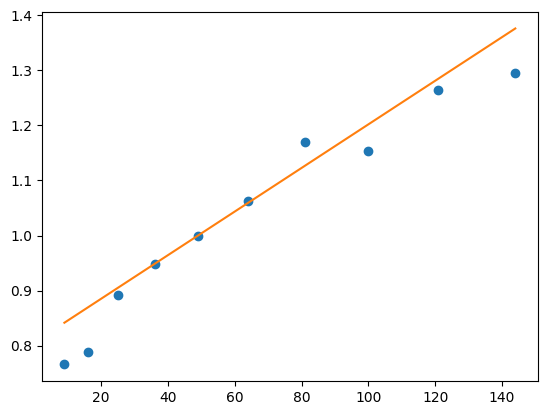

In [17]:
plt.plot(np.arange(3,13)**2, scale, 'o')
plt.plot(np.arange(3,13)**2, fit_func(np.arange(3,13)**2, *p) + (1 - 0.97249001))

In [11]:
np.round(scale,4)

array([0.7658, 0.7883, 0.8914, 0.9488, 1.    , 1.0621, 1.1702, 1.1536,
       1.2635, 1.2949])

## Random Network

In [7]:
results_r   = {}
V_arr       = np.zeros((100,3))
V_min       = 0.5
V_max       = 1.0
V_arr[:,0]  = np.linspace(V_min, V_max, 100, endpoint=True)

for N in np.arange(10,101,5):
    stats = {}
    for s in range(10):

        topology_parameter  = return_random_topology(N)
        np_network_cubic    = nanonets.simulation(network_topology='random', topology_parameter=topology_parameter, seed=s)
        
        np_network_cubic.run_const_voltages(V_arr, 1, save_th=0.1)
        stats[s] = np_network_cubic.return_output_values()
        
    results_r[N] = stats

In [28]:
dic_r_new = {}

for N in np.arange(10,101,5):

    values = np.zeros(results_r[N][0].shape)

    for key, val in results_r[N].items():

        values += val/10

    dic_r_new[N] = values

In [36]:
p_vals = []

for N in dic_r_new.keys():

    p, cov = curve_fit(fit_func, V_arr[:,0], dic_r_new[N][:,2])

    p_vals.append(p)

In [41]:
slopes  = np.array([p[0] for p in p_vals])
# scale   = slopes[4]/slopes
# p, cov  = curve_fit(fit_func, np.arange(3,13)**2, scale)

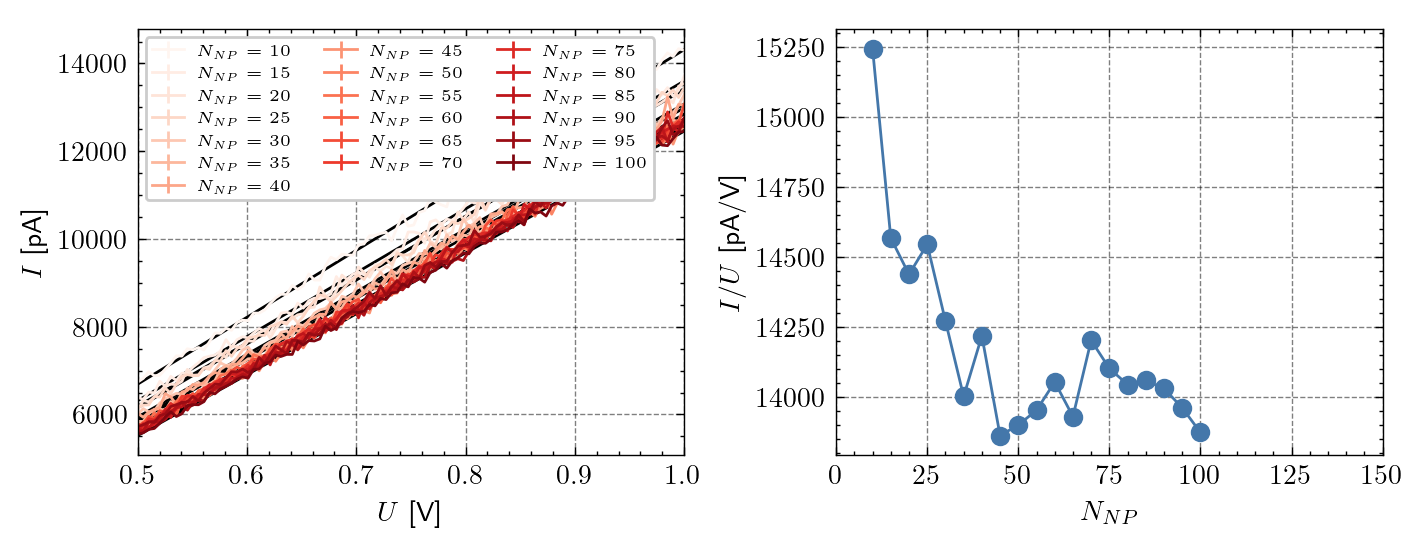

In [44]:
cmap = plt.get_cmap('Reds')

with plt.style.context(["science", "bright", "grid"]):

    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*2)
    ax  = fig.add_subplot(1,2,1)

    for i, N in enumerate(np.arange(10,101,5)):

        ax.errorbar(V_arr[:,0], dic_r_new[N][:,2], 0, c=cmap(i/len(dic_r_new.keys())), label='$N_{NP} = '+f' {N}$')
        ax.plot(V_arr[:,0], fit_func(V_arr[:,0], *p_vals[i]), 'black')
    
    ax.set_ylabel("$I$ [pA]")
    ax.set_xlabel("$U$ [V]")
    ax.legend(fontsize='xx-small', ncol=3)
    ax.set_xlim(0.5,1.0)

    ax  = fig.add_subplot(1,2,2)

    ax.plot(np.arange(10,101,5), slopes, '-o')
    ax.set_ylabel('$I/U$ [pA/V]')
    ax.set_xlabel("$N_{NP}$")
    ax.set_xlim(0,150)
    # fig.savefig("docs/I_V_cubic_network.png")

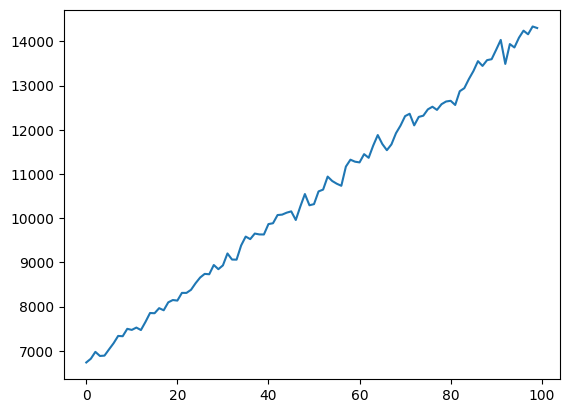

In [24]:
plt.plot(values[:,2])

## String of Nanoparticles

In [28]:
results     = {}
V_arr       = np.zeros((100,3))
V_min       = 0.5
V_max       = 1.0
V_arr[:,0]  = np.linspace(V_min, V_max, 100, endpoint=True)

for N in range(2,100,2):

    topology_parameter  = return_string_topology(N)
    np_network_cubic    = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter)
    
    np_network_cubic.run_const_voltages(V_arr, 1, save_th=0.1)

    results[N] = np_network_cubic.return_output_values()

In [29]:
p_vals = []

for N in results.keys():

    p, cov = curve_fit(fit_func, V_arr[:,0], results[N][:,2])

    p_vals.append(p)

/home/jonas/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [30]:
slopes  = np.array([p[0] for p in p_vals])
scale   = slopes[5]/slopes

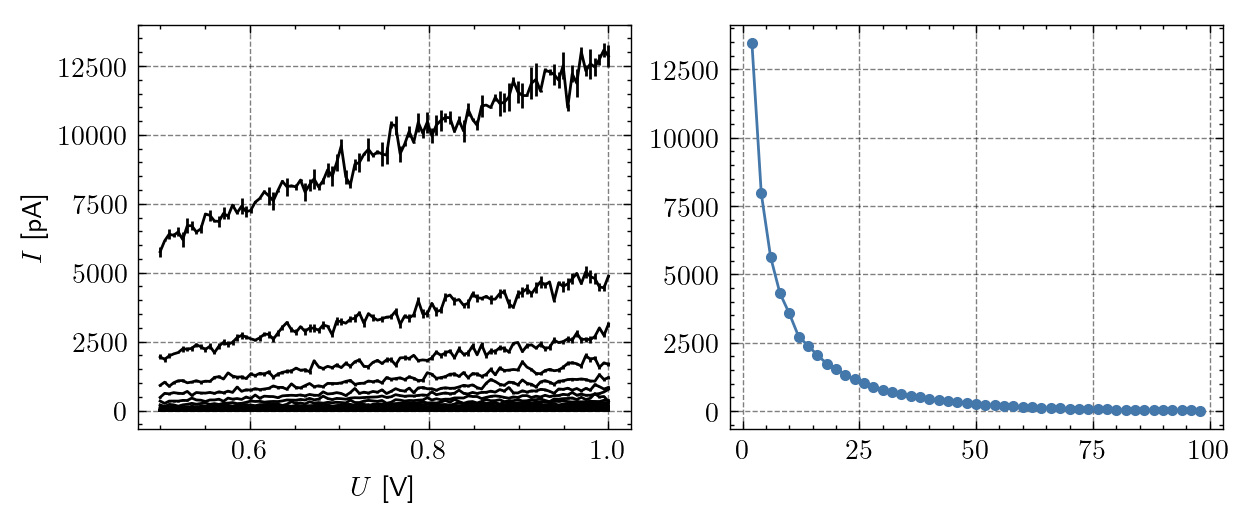

In [46]:
with plt.style.context(["science", "bright", "grid"]):

    fig = plt.figure(dpi=200)
    fig.set_figwidth(fig.get_figwidth()*2)
    ax  = fig.add_subplot(1,2,1)

    for i, N in enumerate(range(2,100,4)):

        ax.errorbar(V_arr[:,0], results[N][:,2], results[N][:,3], c='black')
        # ax.plot(V_arr[:,0], fit_func(V_arr[:,0], *p_vals[i]), 'black')
    
    ax.set_ylabel("$I$ [pA]")
    ax.set_xlabel("$U$ [V]")
    # ax.set_ylim(0,1000)

    ax  = fig.add_subplot(1,2,2)

    ax.plot(np.arange(2,100,2), slopes, '.-')